# Automatic differentiation

*Selected Topics in Mathematical Optimization*

**Michiel Stock** ([email](michiel.stock@ugent.be))

![](Figures/logo.png)

In [10]:
using Plots, BenchmarkTools

In [3]:
f(x) = log(x) + sin(x) / x

f (generic function with 1 method)

## Symbolic differentiation

Computing derivatives as you have seen in basic calculus courses. 

By hand or automatically:
- Maple
- Sympy (python)
- Mathematica
- Maxima

Differentiation is *easy* compared to *integration* or *sampling*.

Advantages:
- exact derivatives!
- gives the formula for different evaluations.
- no hyperparameters or tweaking: just works!

Disadvantages:
- some software not flexible enough (gradients, arrays, for-loops...)
- sometimes explosion of terms: *expression swell*
- not always numerically optimal!

In [4]:
using SymEngine

In [5]:
@vars x  # define variable

(x,)

In [6]:
df = diff(f(x), x)

-sin(x)/x^2 + cos(x)/x + x^(-1)

In [7]:
df(2.0)

0.0646022250200084

## Numerical differentiation

Finite difference approximation of the derivative/gradient based on a number of function evaluations.

Often based on the limit definition of a derivative. Theoretical analysis using Taylor approximation:

$$
f(x + h) = f(x) + \frac{h}{1!} + \frac{h^2}{2!}f''(x) + \frac{h^3}{3!}f^{(3)}(x)+\ldots
$$

**Divided difference**

$$
f'(x)\approx \frac{f(x+h) - f(x)}{h}
$$


**Center difference**

$$
f'(x)\approx \frac{f(x+h) - f(x-h)}{2h}
$$


**Complex step method**

$$
f'(x)\approx \frac{\text{Im} (f(x +ih))}{h}
$$

Some simple implementations:

In [8]:
diff_divdiff(f, x; h=1e-10) = (f(x + h) - f(x)) / h
diff_centdiff(f, x; h=1e-10) = (f(x + h) - f(x - h)) / 2h 
diff_complstep(f, x; h=1e-10) = imag(f(x + im * h)) / h

diff_complstep (generic function with 1 method)

In [11]:
@btime diff_divdiff($f, 2.0)

  5.945 ns (0 allocations: 0 bytes)


0.06460165735688861

In [12]:
@btime diff_centdiff($f, 2.0)

  6.001 ns (0 allocations: 0 bytes)


0.06460165735688861

In [13]:
@btime diff_complstep($f, 2.0)

  71.994 ns (0 allocations: 0 bytes)


0.06460222502000833

In [16]:
error(diff, h; x=2.0) = max(abs(Float64(df(x)) - diff(f, x, h=h)), 1e-30);
stepsizes = map(t->10.0^t, -20:0.5:-1);

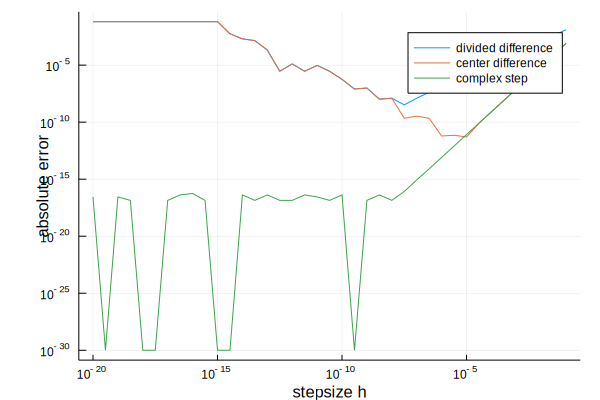

In [17]:
plot(stepsizes, error.(diff_divdiff, stepsizes), label="divided difference",
    xscale=:log10, yscale=:log10)
plot!(stepsizes, error.(diff_centdiff, stepsizes), label="center difference")
plot!(stepsizes, error.(diff_complstep, stepsizes), label="complex step")
#xlims!(1e-15, 1e-1)
xlabel!("stepsize h")
ylabel!("absolute error")

Advantages of numerical differentiation:
- easy to implement
- general, no assumptions needed

Disadvantages:
- not numerically stable (round-off errors)
- not efficient for gradients ($\mathcal{O}(n)$ evaluations for $n$-dimensional vectors)

**First sin of numerical analysis**:

> *thou shalt not add small numbers to big numbers*

**second sin of numerical analysis**:

> *thou shalt not subtract numbers which are approximately equal*

### Stein's lemma

$$
E_{X\sim N(\mu, \sigma)}[f(X)(X-\mu)] = \sigma^2 E_{X\sim N(\mu, \sigma)}[f'(X)]
$$

and thus, using $X = x + \sigma\epsilon$ with $\epsilon\sim N(0, 1)$:

$$
E_{\epsilon\sim N(0, 1)}[f'(x + \sigma\epsilon)] = \frac{1}{\sigma} E_{\epsilon\sim N(0, 1)}[f(x+\sigma \epsilon)\epsilon]
$$

In [99]:
diff_stein(f, x; σ=1e-1, n=10_000) = 1 / σ * sum(map(e -> f(x + σ * e) * e, randn(n))) / n

diff_stein (generic function with 1 method)

In [101]:
diff_stein(f, 2.0)

0.06730957292876388

### Approximations of multiplications with gradients

**Gradient-vector approximation**

$$
\nabla f(\mathbf{x})^\intercal \mathbf{d} \approx \frac{f(\mathbf{x}+h\cdot\mathbf{d}) - f(\mathbf{x}-h\cdot\mathbf{d})}{2h}
$$

**Hessian-vector approximation**

$$
\nabla^2 f(\mathbf{x}) \mathbf{d} \approx \frac{\nabla f(\mathbf{x}+h\cdot\mathbf{d}) - \nabla f(\mathbf{x}-h\cdot\mathbf{d})}{2h}
$$

In [25]:
grad_vect(f, x, d; h=1e-10) = (f(x + h * d) - f(x - h * d)) / (2h)

grad_vect (generic function with 1 method)

In [26]:
dvect = randn(10) / 10
xvect = 2rand(10)

A = randn(10, 10)
A = A * A' / 100

#g(x) = exp(- x' * A * x)  # adjoint does not play with Zygote
g(x) = exp(- sum(x .* (A * x)))

∇g(x) = -2g(x) * A * x
∇²g(x) = -2g(x) * A - 2A * x * ∇g(x)'

∇²g (generic function with 1 method)

In [27]:
g(xvect)

0.37350022994849946

In [28]:
∇g(xvect)

10-element Array{Float64,1}:
 -0.2057850440259106  
  0.027457997637599128
 -0.06773790844531756 
 -0.012583957084079167
 -0.1448102785215536  
 -0.16783920785286385 
 -0.042820214761988704
 -0.05416688187572384 
  0.11157218722170226 
  0.10894114579306909 

In [29]:
∇g(xvect)' * dvect

0.052412939370748396

In [30]:
grad_vect(g, xvect, dvect)

0.05241418410406595

In [31]:
∇²g(xvect) * dvect

10-element Array{Float64,1}:
 -0.010628569566416947 
  0.01323235463777969  
 -0.011107212257082655 
  0.0026457562301251307
 -0.008467047960303422 
 -0.0057613106905093385
 -0.012628867883242969 
 -0.008036541134864654 
  0.00149218161001998  
 -0.00916031018097086  

In [32]:
h = 1e-10
(∇g(xvect + h * dvect) - ∇g(xvect - h * dvect)) / (2h)

10-element Array{Float64,1}:
 -0.010629414015639327 
  0.013232453327516325 
 -0.011107434416679496 
  0.002645661467681748 
 -0.00846753223093799  
 -0.0057620574978045624
 -0.012628995071928273 
 -0.00803673100291391  
  0.0014924866897914058
 -0.009159617508913698 

## Forward differentiation

Accumulation of the gradients along the *computational graph*. 

<img src="Figures/compgraph.png" alt="drawing" width="400"/>

Forward differentiation computes the gradient from the inputs to the outputs.

### Differentiation rules

**Sum rule**:

$$
\frac{\partial (f(x)+g(x))}{\partial x} =  \frac{\partial f(x)}{\partial x} + \frac{\partial f(x)}{\partial x} 
$$

**Product rule**:

$$
\frac{\partial (f(x)g(x))}{\partial x} =  f(x)\frac{\partial g(x)}{\partial x} + g(x)\frac{\partial f(x)}{\partial x} 
$$

**Chain rule**:

$$
\frac{\partial (g(g(x))}{\partial x} =  \frac{\partial g(u)}{\partial u}\mid_{u=f(x)} \frac{\partial f(x)}{\partial x} 
$$

### Example of the forward differentiation

<img src="Figures/forwarddiff.png" alt="drawing" width="600"/>

### Dual numbers

Forward differentiation can be viewed as evaluating function using *dual numbers*, which can be viewed as truncated Taylor series:

$$
v + \dot{v}\epsilon\,,
$$

where $v,\dot{v}\in\mathbb{R}$ and $\epsilon$ a nilpotent number, i.e. $\epsilon^2=0$. For example, we have

$$
(v + \dot{v}\epsilon) + (u + \dot{u}\epsilon) = (v+u) + (\dot{v} +\dot{u})\epsilon
$$


$$
(v + \dot{v}\epsilon)(u + \dot{u}\epsilon) = (vu) + (v\dot{u} +\dot{v}u)\epsilon\,.
$$



These dual numbers can be used as

$$
f(v+\dot{v}) = f(v) + f'(v)\dot{v}\epsilon\,.
$$

In [33]:
struct Dual
    v
    v̇
end

In [43]:
Base.:+(a::Dual, b::Dual) = Dual(a.v + b.v, a.v̇ + b.v̇)
Base.:*(a::Dual, b::Dual) = Dual(a.v * b.v, a.v * b.v̇ + b.v * a.v̇)
Base.:*(v::Real, b::Dual) = Dual(v, 0.0) * b
Base.:sin(a::Dual) = Dual(sin(a.v), cos(a.v) * a.v̇)
Base.:log(a::Dual) = Dual(log(a.v), 1.0 / a.v * a.v̇)
Base.:/(a::Dual, b::Dual) = Dual(a.v / b.v, (a.v̇ * b.v - a.v * b.v̇) / b.v^2)

In [36]:
@btime f(Dual(2.0, 1.0))

  56.400 ns (6 allocations: 144 bytes)


Dual(1.1477958939727861, 0.06460222502000834)

In [70]:
myforwarddiff(f, x) = f(Dual(x, 1.0)).v̇

@btime myforwarddiff($f, 2.0)

  59.146 ns (6 allocations: 144 bytes)


0.06460222502000834

This directly works for vectors!

In [53]:
q(x) = 10.0 * x[1] * x[2] + x[1] * x[1] + sin(x[1]) / x[2]

q (generic function with 1 method)

In [52]:
q([1, 2])

21.42073549240395

In [61]:
q(Dual.([1, 2], [1, 0]))  # partial wrt x1

Dual(21.42073549240395, 22.27015115293407)

In [62]:
q(Dual.([1, 2], [0, 1]))  # partial wrt x2

Dual(21.42073549240395, 9.789632253798025)

In [63]:
using ForwardDiff

In [68]:
@btime ForwardDiff.derivative($f, 2.0)

  2.665 ns (0 allocations: 0 bytes)


0.06460222502000834

In [69]:
@btime ForwardDiff.gradient($g, $xvect)

  2.340 μs (10 allocations: 4.23 KiB)


10-element Array{Float64,1}:
 -0.20578504402591058 
  0.027457997637599124
 -0.06773790844531753 
 -0.012583957084079186
 -0.14481027852155356 
 -0.16783920785286385 
 -0.0428202147619887  
 -0.05416688187572384 
  0.11157218722170223 
  0.1089411457930691  

In [66]:
ForwardDiff.gradient(q, [1, 2])

2-element Array{Float64,1}:
 22.27015115293407 
  9.789632253798025

Forward differentiation:

- exact gradients!
- computational complexity scales with **number of inputs**
- used when you have more outputs than inputs

## Reverse differentiation

Compute the gradient from the output toward the inputs using the chain rule.

<img src="Figures/reversediff.png" alt="drawing" width="600"/>

Reverse differentiation:

- also exact!
- main workhorse for training artificial neural networks!
- efficient when more inputs than outputs (machine learning: thousands of parameters vs. one loss)

In [72]:
using Zygote

In [73]:
@btime f'(2.0)

  2.667 ns (0 allocations: 0 bytes)


0.06460222502000834

In [74]:
@btime g'(xvect)

  5.957 μs (46 allocations: 3.52 KiB)


10-element Array{Float64,1}:
 -0.20578504402591058 
  0.027457997637599124
 -0.06773790844531755 
 -0.012583957084079195
 -0.1448102785215536  
 -0.16783920785286388 
 -0.042820214761988704
 -0.05416688187572384 
  0.11157218722170226 
  0.10894114579306913 

## Application: deep learning

Multi-layer perceptron.

<img src="Figures/ANN_example.png" alt="drawing" width="200"/>

Reverse differentation or backpropagation.

<img src="Figures/Forwardprop.png" alt="drawing" width="500"/>

Reverse differentation or backpropagation.

<img src="Figures/Backprop.png" alt="drawing" width="500"/>

## Exercise: logistic regression

Recall logistic regression on a training set $S=\{(\mathbf{x}_i, y_i)\mid i=1,\ldots,n\}$ with $y\in\{0,1\}$.

Prediction:

$$
f(\mathbf{x}) = \sigma(\mathbf{w}^\intercal\mathbf{x})\,,
$$

with $\sigma(t) = 1 /(1+exp(t))$.

To find the parameter vector $\mathbf{w}$, we minimize the cross-entropy:

$$
L(\mathbf{w};S)= \sum_{i=1}^n = - y_i \log(f(\mathbf{x})) - (1-y_i)\log(1-f(\mathbf{x}))\,.
$$

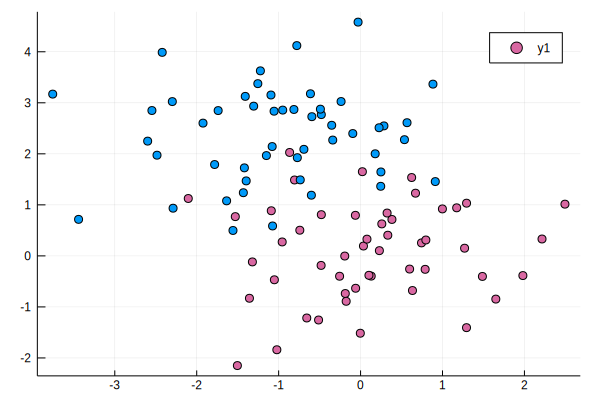

In [136]:
# artificial data
X = [randn(50, 2); randn(50, 2) .+ [-1.0 2.4]];
y = [i <= 50 ? 0 : 1 for i in 1:100];
n = length(y);

scatter(X[:,1], X[:,2], color=y)

In [147]:
σ(t) = 1.0 / (1.0 + exp(t))
f(x, w) = σ(sum(x .* w))
L(w; X=X, y=y) = sum(- y .* log.(σ.(X * w)) - (1.0 .- y) .* log.(σ.(1. .- X * w)))

Ls (generic function with 1 method)

In [151]:
w = [0.1, 0.1]
L(w)

103.43560302829401

**Assignments**

1. Compute the gradient of $L$ wrt. $\mathbf{w}$ using
    - numerical method
    - forward differentiation
    - backward differentiation
2. (optional) Implement a simple gradient descent to find  $\mathbf{w}^\star$.
3. Add a bias to the prediction function.

## Differentiating ODE

Automatic differentiation can be used beyond machine learning and optimization:

- [physical engines](https://arxiv.org/abs/1611.01652) to learn robot control
- differentiating [protein](https://github.com/lupoglaz/TorchProteinLibrary) [structures](https://www.cell.com/cell-systems/fulltext/S2405-4712(19)30076-6)
- Sinkhorn algorithm
- [dynamic programming](https://arxiv.org/abs/1802.03676)
- [differential equations](https://julialang.org/blog/2019/01/fluxdiffeq)

Everything is computed by some straightforward and differentiable functions!

### Short introduction to differential equations

Ordinary differential equations describe dynamical processes through the *rate of change*:

$$
\dot{\mathbf{x}} = f(\mathbf{x}, t)\,.
$$

Usually solved iteratively, for example using Euler's method:

$$
\mathbf{x}_{t+1} = \mathbf{x}_{t} + \alpha_t f(\mathbf{x}_{t}, t)\,.
$$

with $\alpha_t$ a stepsize (does this remind you of something?).

In [169]:
function eulersolve(fun, u0, (t0, tend), p, stepsize=0.1)
    u = copy(u0)
    du = similar(u)
    for t in t0:stepsize:tend
        fun(du, u, p, t)
        u .+= stepsize * du
    end
    return u
end

eulersolve (generic function with 2 methods)